https://www.kaggle.com/code/rv1922/s4-e10-loan-approval-catboost-auc-roc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir('E:\Python code\Loan Approval Prediction')

In [3]:
train1 = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
original = pd.read_csv('credit_risk_dataset.csv')

In [4]:
train = pd.concat([train1, original], ignore_index=True)
train['id'] = np.arange(91226)

In [5]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          91226 non-null  int32  
 1   person_age                  91226 non-null  int64  
 2   person_income               91226 non-null  int64  
 3   person_home_ownership       91226 non-null  object 
 4   person_emp_length           90331 non-null  float64
 5   loan_intent                 91226 non-null  object 
 6   loan_grade                  91226 non-null  object 
 7   loan_amnt                   91226 non-null  int64  
 8   loan_int_rate               88110 non-null  float64
 9   loan_percent_income         91226 non-null  float64
 10  cb_person_default_on_file   91226 non-null  object 
 11  cb_person_cred_hist_length  91226 non-null  int64  
 12  loan_status                 91226 non-null  int64  
dtypes: float64(3), int32(1), int64(

In [7]:
train.isnull().sum()

id                               0
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,91226.0,45612.500000,26334.822166,0.00,22806.25,45612.50,68418.75,91225.00
person_age,91226.0,27.616480,6.148115,20.00,23.00,26.00,30.00,144.00
person_income,91226.0,64770.706224,47936.961097,4000.00,40000.00,57000.00,78000.00,6000000.00
person_emp_length,90331.0,4.732119,4.025068,0.00,2.00,4.00,7.00,123.00
loan_amnt,91226.0,9350.348607,5848.605423,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,88110.0,10.789508,3.108998,5.42,7.88,10.95,13.11,23.22
loan_percent_income,91226.0,0.163154,0.097491,0.00,0.09,0.14,0.22,0.83
cb_person_cred_hist_length,91226.0,5.810219,4.038412,2.00,3.00,4.00,8.00,30.00
loan_status,91226.0,0.169447,0.375149,0.00,0.00,0.00,0.00,1.00


In [9]:
train['person_emp_length'] = train['person_emp_length'].fillna(train['person_emp_length'].median())
train['loan_int_rate'] = train['loan_int_rate'].fillna(train['loan_int_rate'].median())

In [10]:
train = train[(train.person_age<=100) & (train.person_emp_length<=100)].reset_index(drop=True)

In [11]:
def preprocess_data(train, test):
    # Encoding categorical variables
    train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
    train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
    train['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
    train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)
    
    test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
    test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
    test['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
    test['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)

    # Handling missing values and converting data types
    test['person_emp_length'] = test['person_emp_length'].fillna(original['person_emp_length'].mean())
    test['person_emp_length'] = test['person_emp_length'].astype(int)
    test['loan_int_rate'] = test['loan_int_rate'].fillna(original['loan_int_rate'].mean())
    test['loan_int_rate'] = (test['loan_int_rate'] * 100).astype(int)
    test['loan_percent_income'] = (test['loan_percent_income'] * 100).astype(int)

    train['person_emp_length'].fillna(original['person_emp_length'].mean(), inplace=True)
    train['person_emp_length'] = train['person_emp_length'].astype(int)
    train['loan_int_rate'] = train['loan_int_rate'].fillna(original['loan_int_rate'].mean())
    train['loan_int_rate'] = (train['loan_int_rate'] * 100).astype(int)
    train['loan_percent_income'] = (train['loan_percent_income'] * 100).astype(int)
    
    return train, test

In [12]:
train, test = preprocess_data(train, test)

# Train Model

In [13]:
X = train.drop(columns=['loan_status'])
y = train['loan_status']

In [14]:
catboost_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.08114394459649094,
    'iterations': 1000,
    'depth': 6,
    'random_strength': 0,
    'l2_leaf_reg': 0.7047064221215757,
    'task_type': 'GPU',
    'random_seed': 42,
    'verbose': False
}

In [15]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)

In [16]:
scores = []
test_preds = []

In [17]:
X_test_pool = Pool(test, cat_features=X.columns.values)

In [18]:
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostClassifier(**catboost_params)
    
    X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
    y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
    
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
    
    val_pred = model.predict_proba(X_valid_pool)[:, 1]
    score = roc_auc_score(y_val_fold, val_pred)
    scores.append(score)
    
    print(f'Fold {i + 1} roc_auc_score: {score}')
    
    test_pred = model.predict_proba(X_test_pool)[:, 1]
    test_preds.append(test_pred)

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 roc_auc_score: 0.9683513232363111


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 roc_auc_score: 0.9672331054801264


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 roc_auc_score: 0.968232169595484


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 roc_auc_score: 0.9652028643980191


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 roc_auc_score: 0.9642011099772921


# Model Evaluation

In [19]:
print(f'Cross-validated roc_auc_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max roc_auc_score: {np.max(scores):.3f}')
print(f'Min roc_auc_score: {np.min(scores):.3f}')

Cross-validated roc_auc_score: 0.967 +/- 0.002
Max roc_auc_score: 0.968
Min roc_auc_score: 0.964


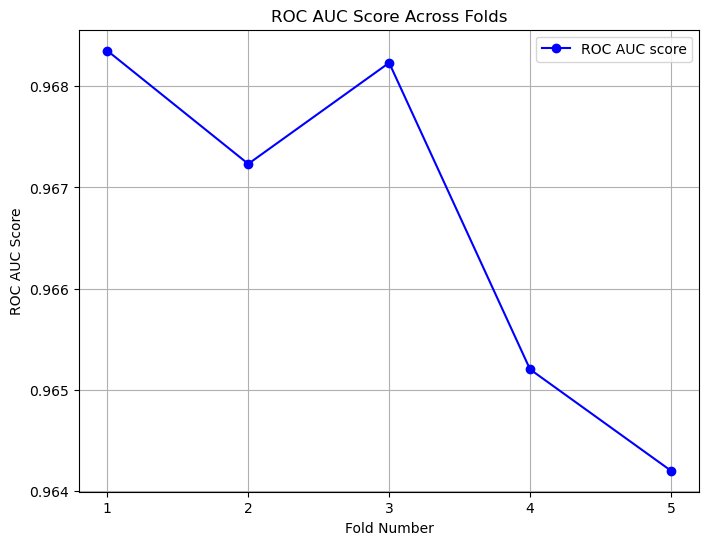

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='b', label='ROC AUC score')
plt.title('ROC AUC Score Across Folds')
plt.xlabel('Fold Number')
plt.ylabel('ROC AUC Score')
plt.xticks(range(1, len(scores) + 1))
plt.grid(True)
plt.legend()
plt.show()

# Prediction

In [21]:
final_pred_test = np.mean(test_preds, axis=0)

submission = test[['id']].copy()
submission['loan_status'] = final_pred_test  
print(submission)

          id  loan_status
0      58645     0.999955
1      58646     0.019122
2      58647     0.410390
3      58648     0.005121
4      58649     0.023303
...      ...          ...
39093  97738     0.077962
39094  97739     0.004157
39095  97740     0.003585
39096  97741     0.256335
39097  97742     0.960501

[39098 rows x 2 columns]


In [22]:
submission.to_csv('submission.csv', index=False)
print("File Saved!!")

File Saved!!
